In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
import keras
from keras import layers, optimizers

from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary

from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder

import keras_tuner as kt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/suicidal-mental-health-dataset/mental-health.csv


In [2]:
df = pd.read_csv('/kaggle/input/suicidal-mental-health-dataset/mental-health.csv')

df['label'] = df['label'].str.replace('SuicideWatch', 'suicidal')
df['label'] = df['label'].str.lower()

binarized = []
for label in df['label']:
    if label == 'suicidal':
        binarized.append(1)
    else:
        binarized.append(0)

binarized = pd.Series(binarized, name='label')
df = df.drop('label', axis=1)
df = pd.concat([df, binarized], axis=1)

train_df, other = train_test_split(
    df,
    test_size = 0.12,
    random_state = 9740,
    shuffle = True,
    stratify = df['label'],
)

val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9740,
    shuffle = True,
    stratify = other['label'],
)

In [3]:
BATCH_SIZE = 64
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['label'].values)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [5]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b'i feel as if i am chained to the ground or submerged in mud, i have no wish or will to get better, there is nothing in this world that i would rather be doing than sleeping, i cannot move, i barely have the energy to breathe, too exhausted to live.i am imprisoned in my own body. complete and utter apathy'
0

b'(i live in canada) i was thinking of ending it all during the summer by just not sleeping until i just die but is there a more efficient way? how can i kill myself at age 13 without a gun?'
1

b'hey, so i have been having trouble crying recently because i have been holding in my tears for far to long, so could somebody just write anything in the chat thingy to try and help me cry. you do not have to, but it would be nice.'
0



In [6]:
reserved_tokens = ["[PAD]", "[UNK]"]

#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

80953


In [7]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1024).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [8]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [9]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [10]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'i feel as if i am chained to the ground or submerged in mud, i have no wish or will to get better, there is nothing in this world that i would rather be doing than sleeping, i cannot move, i barely have the energy to breathe, too exhausted to live.i am imprisoned in my own body. complete and utter apathy', shape=(), dtype=string)
Tokens:  tf.Tensor(
[  46   92  116  105   46   73 4281  318   68   71 1751   98 1402 4472
 2419   81 7954   13   46   77  107  233   98  104   68  109  162   13
  129   75  163   81   85  246   80   46  115  585   90  220  197  768
   13   46   97  415   13   46  476   77   71  488   68 1421   13  169
  747   68  182   15   46   73 8523   81   70  281  367   15  959   69
 3118 2456    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  

In [11]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()

In [12]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [13]:
def FentTweaker():
    input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=True,
    )(input_ids)
    
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    x = layers.Dropout(0.10)(x)
    
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    x = layers.Dropout(0.0)(x) #this does nothing anyway
    
    #x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.10)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input_ids, outputs, name="FentTweaker9735")
    model.compile(
        optimizer = optimizers.Adam(
            learning_rate = 3e-4
        ),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    return model

In [14]:
FentTweaker9740 = FentTweaker()
FentTweaker9740.summary()

Model: "FentTweaker9735"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 128)           │      10,427,520 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder (FNetEncoder)          │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_1 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,692,097 (40.79 MB)

 Trainable params: 10,692,097 (40.79 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.0974,
    patience = 3,
    verbose = 1,
    mode = "auto",
    min_delta = 3e-4,
    cooldown = 0,
    min_lr = 3e-6,
)

In [17]:
earlyStop = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0.001,
    patience = 4,
    verbose = 1,
    mode = "auto",
    restore_best_weights = False,
    start_from_epoch = 6,
)

In [19]:
modelCkpt = keras.callbacks.ModelCheckpoint(
    filepath = "/kaggle/working/checkpoint.model.keras",
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    save_freq = "epoch",
)

In [21]:
history = FentTweaker9740.fit(
    train_dataset,
    epochs=20, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR, modelCkpt]
)

Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5169 - loss: 0.6992 - val_accuracy: 0.5761 - val_loss: 0.6709 - learning_rate: 3.0000e-04
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.6506 - loss: 0.6190 - val_accuracy: 0.6874 - val_loss: 0.5940 - learning_rate: 3.0000e-04
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7226 - loss: 0.5494 - val_accuracy: 0.6997 - val_loss: 0.5819 - learning_rate: 3.0000e-04
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7556 - loss: 0.5072 - val_accuracy: 0.6874 - val_loss: 0.5959 - learning_rate: 3.0000e-04
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7782 - loss: 0.4731 - val_accuracy: 0.6874 - val_loss: 0.6121 - learning_rate: 3.0000e-04
Epoch 6/20
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8009 - loss: 0.4405
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9220001387875527e-05.
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accura

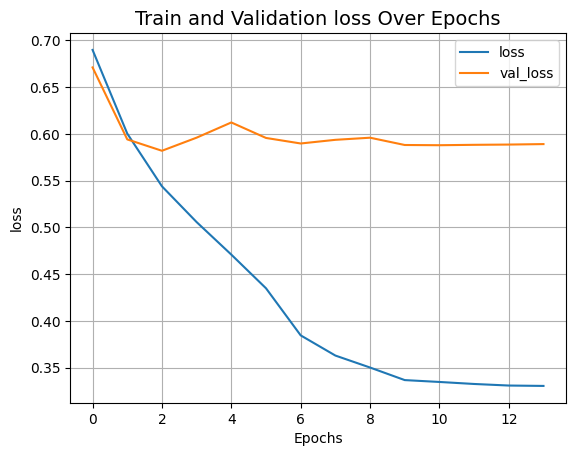

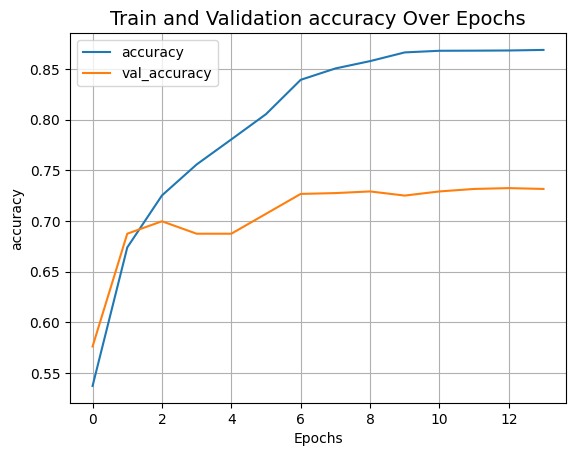

In [22]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [24]:
FentTweaker9740.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6908 - loss: 0.6194


[0.6169601678848267, 0.6939443349838257]